<a href="https://colab.research.google.com/github/lucatraverso/House-price-prediction_Prosperati-dataset./blob/main/prosperati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicción de precios de alquileres en CABA

En este colab vamos a explorar el dataset de inmuebles de Prosperati y vamos a armar un modelo predictivo probando diferentes algoritmos. Primero que nada hay que importar las librerias y modulos necesarios.

In [1]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

##Obtencion del dataset

Ahora descargamos e importamos el dataset.

In [2]:
!wget https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz

--2021-07-11 17:25:09--  https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 142.250.188.208, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296076817 (282M) [application/octet-stream]
Saving to: ‘ar_properties.csv.gz.6’

ar_properties.csv.g 100%[===================>] 282.36M   190MB/s    in 1.5s    

2021-07-11 17:25:11 (190 MB/s) - ‘ar_properties.csv.gz.6’ saved [296076817/296076817]



In [3]:
with gzip.open('ar_properties.csv.gz') as f:
    dataset = pd.read_csv(f)

##Explorando el dataset



In [4]:
dataset.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,DyVXfkpKygVBKuUk5olH+A==,Propiedad,2020-08-22,2020-09-03,2020-08-22,-34.407468,-58.957367,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,NaN,NaN,NaN,NaN,NaN,NaN,133139.0,NaN,NaN,NaN,Mensual,VENTA - Lote Industrial 130.000m2 - Parque Ind...,Lote (Nro.50) mide 133.139 m2\n<br>Valor: U$S ...,Lote,Venta
1,9naojilaMecJN4jlQiTkGg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-37.996039,-57.542509,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,NaN,NaN,NaN,8.0,NaN,NaN,687.0,687.0,NaN,NaN,Mensual,Casa - Santa Cecilia,Conjunto edilicio de casa y departamentos en b...,Otro,Venta
2,tlCPRJPjoDEUzuuCelemAQ==,Propiedad,2020-08-22,2020-08-31,2020-08-22,-31.380187,-58.009182,Argentina,Entre Ríos,Concordia,NaN,NaN,NaN,2.0,1.0,1.0,80.0,80.0,NaN,NaN,Mensual,Casa - Concordia,"Casa de un dormitorio, cocina, baño, living co...",Casa,Alquiler
3,Zw3b91glQUO3HNrM5fPYlQ==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-27.494106,-55.123455,Argentina,Misiones,Oberá,NaN,NaN,NaN,2.0,1.0,1.0,NaN,NaN,NaN,NaN,Mensual,Terreno - Obera,IMPORTANTE PROPIEDAD EN VENTA EN OBERA MISIONE...,Lote,Venta
4,bsU81gm9JEgtZCbTYgvykg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-32.948856,-60.630464,Argentina,Santa Fe,Rosario,NaN,NaN,NaN,3.0,1.0,1.0,76.0,66.0,NaN,NaN,Mensual,Departamento - Rosario,PORTAL DE LOS MARINOS<br>Es un complejo de viv...,Departamento,Venta


In [5]:
print(f'Filas: {dataset.shape[0]}')
print(f'Columnas: {dataset.shape[1]}')
dataset.info()

Filas: 1000000
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1000000 non-null  object 
 1   ad_type          1000000 non-null  object 
 2   start_date       1000000 non-null  object 
 3   end_date         1000000 non-null  object 
 4   created_on       1000000 non-null  object 
 5   lat              884844 non-null   float64
 6   lon              884647 non-null   float64
 7   l1               1000000 non-null  object 
 8   l2               1000000 non-null  object 
 9   l3               965551 non-null   object 
 10  l4               300151 non-null   object 
 11  l5               6114 non-null     object 
 12  l6               0 non-null        float64
 13  rooms            695000 non-null   float64
 14  bedrooms         634736 non-null   float64
 15  bathrooms        765431 non-null   floa

In [6]:
dataset.describe()

,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,884844.000000,884647.000000,0.0,695000.000000,634736.000000,765431.000000,465954.000000,4.750360e+05,9.591210e+05
mean,-34.434899,-59.456957,NaN,2.901554,2.100442,1.719026,523.863180,7.396426e+03,3.465462e+05
std,3.034939,2.770185,NaN,1.734543,2.473024,1.101545,4418.776956,3.249895e+06,5.867155e+06
min,-54.841484,-122.538399,NaN,1.000000,-16.000000,1.000000,-136.000000,-1.300000e+02,0.000000e+00
25%,-34.747574,-58.848835,NaN,2.000000,1.000000,1.000000,50.000000,4.500000e+01,3.800000e+04
50%,-34.594906,-58.486255,NaN,3.000000,2.000000,1.000000,95.000000,7.800000e+01,9.800000e+04
75%,-34.425087,-58.394737,NaN,4.000000,3.000000,2.000000,250.000000,1.690000e+02,2.150000e+05
max,49.633731,8.386075,NaN,40.000000,999.000000,20.000000,200000.000000,2.147484e+09,3.100000e+09


Se ve que los valores maximos se alejan por mucho de su respectivo percentil 75%. 
Vamos a analizar la situacion en CABA. Puntualmente queremos explorar viviendas, por lo cual vamos a dejar afuera oficinas, cocheras, depositos etc.

In [7]:
caba = dataset[(dataset.l2 == 'Capital Federal') & dataset.property_type.isin(['Departamento', 'PH', 'Casa'])]

Veamos la distribucion general de tipos de propiedad en Capital Federal y despues como cambia en cada barrio.

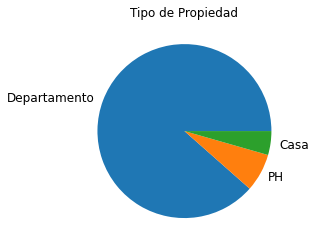

In [8]:
caba['property_type'].value_counts().plot.pie(fontsize=12,
                                              ylabel=' ', 
                                              title='Tipo de Propiedad')

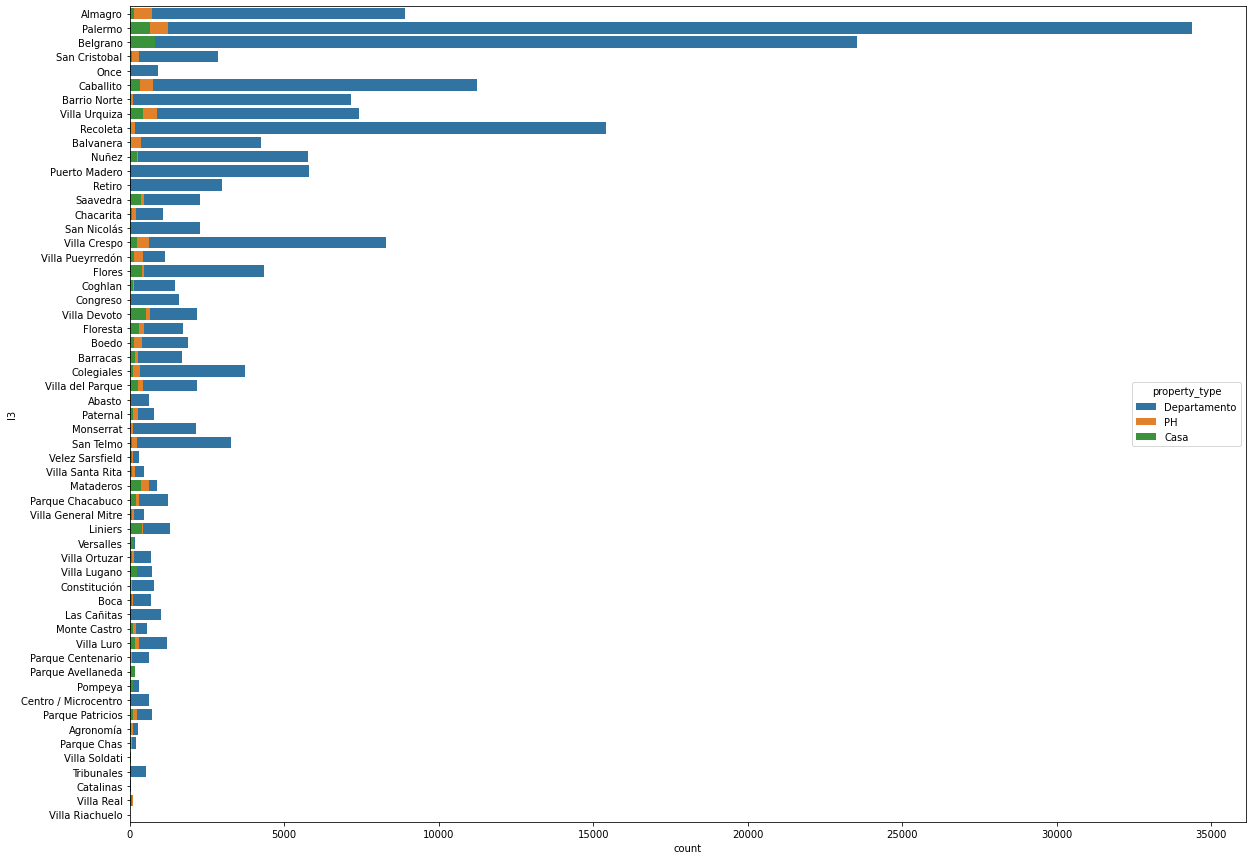

In [9]:
fig, axis = plt.subplots(figsize=(20,15))
sns.countplot(y='l3', 
            hue='property_type', 
            data=caba, 
            dodge=False,
            ax=axis
            )

Ahora nos quedamos solo con las columnas necesarias y graficamos los Boxplots. 

In [10]:
caba = caba[caba.currency == 'ARS']
caba = caba[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']]
caba = caba[caba > 0]
caba = caba.dropna()
caba.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,22782.000000,22782.000000,22782.000000,22782.000000,22782.000000,2.278200e+04
mean,2.391449,1.518392,1.255377,73.914757,72.914977,1.088312e+05
std,1.013041,0.801315,0.583271,554.894006,1026.791379,1.195820e+06
min,1.000000,1.000000,1.000000,10.000000,1.000000,3.500000e+03
25%,2.000000,1.000000,1.000000,40.000000,39.000000,2.500000e+04
50%,2.000000,1.000000,1.000000,52.000000,48.000000,3.500000e+04
75%,3.000000,2.000000,1.000000,74.000000,67.000000,5.000000e+04
max,22.000000,17.000000,12.000000,79000.000000,120000.000000,5.693922e+07


In [11]:
'''caba = caba[caba > 0]
caba = caba.dropna()
caba.describe()'''

'caba = caba[caba > 0]\ncaba = caba.dropna()\ncaba.describe()'

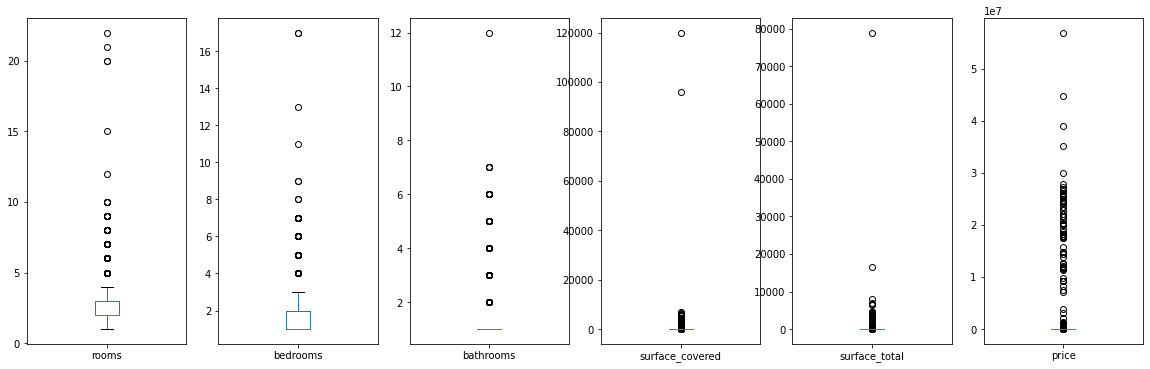

In [12]:
def boxplots():
  fig, axis = plt.subplots(1, 6, figsize=(20, 6))

  caba['rooms'].plot.box(ax=axis[0])
  caba['bedrooms'].plot.box(ax=axis[1])
  caba['bathrooms'].plot.box(ax=axis[2])
  caba['surface_covered'].plot.box(ax=axis[3])
  caba['surface_total'].plot.box(ax=axis[4])
  caba['price'].plot.box(ax=axis[5])

boxplots()


Vamos a filtrar usando el cuantil 0.9 para eliminar outliers. Luego volvemos a ver los boxplots.

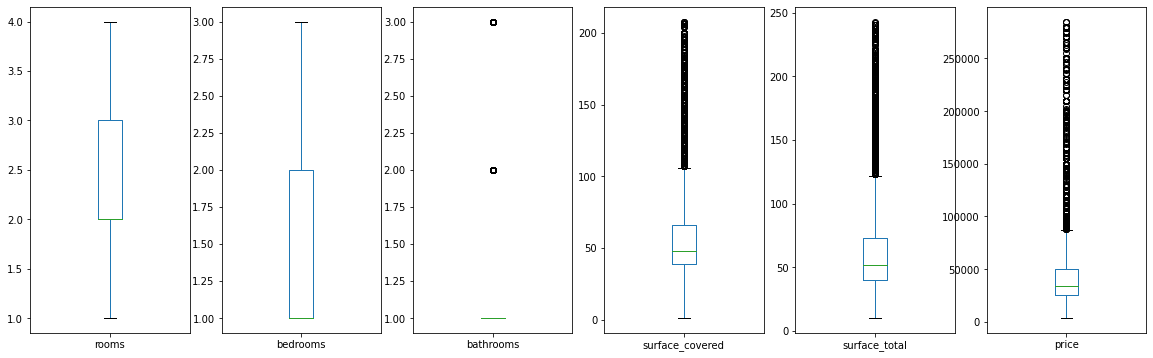

In [13]:
caba = caba[caba.apply(lambda df: df < df.quantile(0.99))]
boxplots()

In [14]:
caba = caba[(caba.surface_total < caba.surface_total.quantile(0.97)) & 
            (caba.price < caba.price.quantile(0.97)) &
            (caba.surface_covered < caba.surface_covered.quantile(0.97))]
        

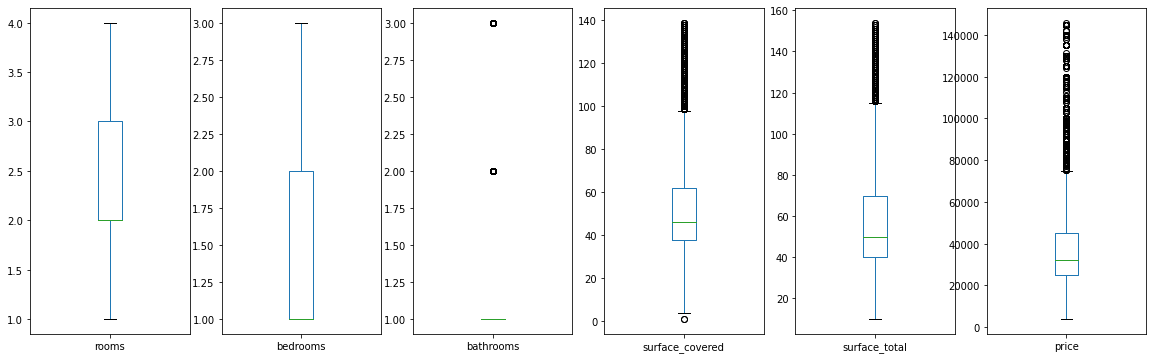

In [15]:
boxplots()

Vamos a recuperar el tipo de propiedad para ver un panorama general de como quedo el dataset.

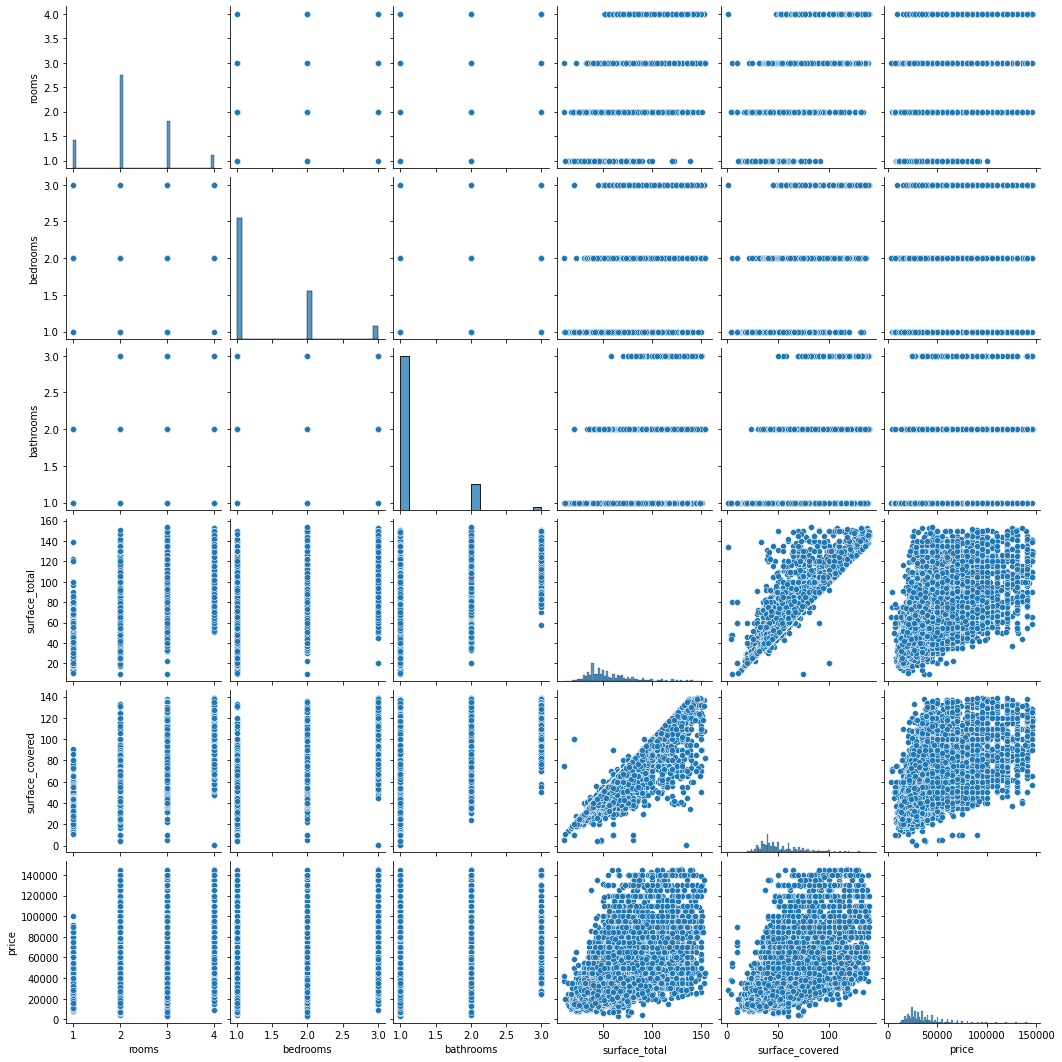

In [16]:
sns.pairplot(caba)

##Definición de modelos

Vamos a usar regresión lineal y una red neuronal.

In [17]:
caba = caba.dropna()
X = caba.drop(['price'], axis=1)
Y = caba['price']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [18]:
#%% REGRESIÓN LINEAL

def entrenar_rlineal(x_train, y_train, x_test, y_test):
    modelo = LinearRegression()
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    train_score = modelo.score(x_train, y_train)
    test_score = modelo.score(x_test, y_test)
    mserror = mean_squared_error(y_test, y_pred, squared=False)
    
    mse = (((y_test - y_pred)**2).sum()) / len(y_test)

    print('Testing linear model...')
    print(f'Training score: {train_score:.2f}')
    print(f'Testing score: {test_score:.2f}')
    print(f'MSError: {mserror:.2f} | {mse:.2f}')
    print('...')
    return modelo


#%% RED NEURONAL

def entrenar_red(x_train, y_train, x_test, y_test, n=(100), 
                 solver='adam', lri=0.001, lr='constant'):
    '''
    Entrena una red 
    n: tupla con en numero de unidades por capa    
    '''
    nn = MLPRegressor(hidden_layer_sizes=n, 
                      activation = 'relu', 
                      solver='adam', 
                      learning_rate_init=lri,
                      learning_rate='constant', 
                      random_state=1
                      )
    nn.fit(x_train, y_train)
    y_pred = nn.predict(x_test)
    train_score = nn.score(x_train, y_train)
    test_score = nn.score(x_test, y_test)
    mserror = mean_squared_error(y_test, y_pred, squared=False)

    print(f'Neural Net with {n} units')
    print(f'Training score: {train_score:.2f}')
    print(f'Testing score: {test_score:.2f}')
    print(f'MSError: {mserror:.2f}')
    print('...')
    return nn

Vamos a probar un par de configuraciones para ver que funciona mejor.

In [19]:
modelo_lineal = entrenar_rlineal(x_train, y_train, x_test, y_test)
red_simple = entrenar_red(x_train, y_train, x_test, y_test, (100), 'adam', 0.1, 'adaptive')
red_doble = entrenar_red(x_train, y_train, x_test, y_test, (100, 50), 'adam', 0.1, 'adaptive')
red_triple = entrenar_red(x_train, y_train, x_test, y_test, (100, 50, 25), 'adam', 0.1, 'adaptive')

Testing linear model...
Training score: 0.44
Testing score: 0.44
MSError: 16613.77 | 276017412.84
...
Neural Net with 100 units
Training score: 0.43
Testing score: 0.44
MSError: 16710.36
...
Neural Net with (100, 50) units
Training score: 0.44
Testing score: 0.44
MSError: 16681.65
...
Neural Net with (100, 50, 25) units
Training score: 0.43
Testing score: 0.43
MSError: 16803.47
...


Text(0.5, 1.0, 'Red Neuronal')

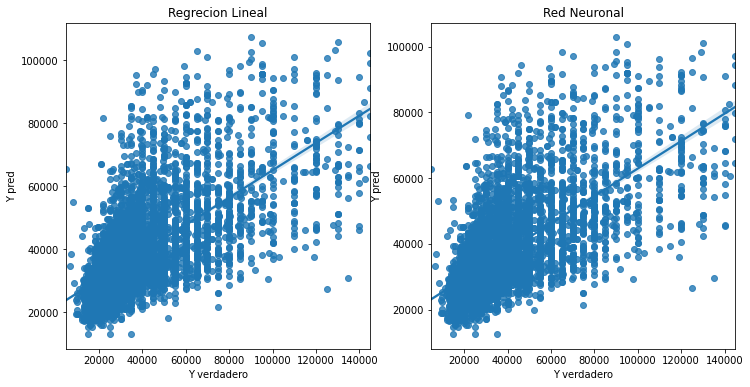

In [20]:
y_lr = modelo_lineal.predict(x_test)
y_nn = red_simple.predict(x_test)

fig, axis = plt.subplots(1, 2, figsize=(12,6))
sns.regplot(x=y_test, y=y_lr, scatter=True, ax=axis[0])
sns.regplot(x=y_test, y=y_nn, scatter=True, ax=axis[1])

axis[0].set_xlabel('Y verdadero')
axis[0].set_ylabel('Y pred')
axis[0].set_title('Regrecion Lineal')
axis[1].set_xlabel('Y verdadero')
axis[1].set_ylabel('Y pred')
axis[1].set_title('Red Neuronal')

Se observan resultados muy similares, tanto en el Error cuadratico medio como en los graficos relacionales entre valores predichos y reales. La gran dispercion hace que los valores arrojados por el modelo no sean confiables. Lo mas conveniente es sumar otras variables al modelo, como bariro o tipo de propiedad.